# Introduction

Its well known that after the emergence of AlexNet in 2013, CNN's became an immense success as a key tool for applying effective deep learning in a broad range of applications, like modeling natural scene images and achieving state-of-the-art results in classification, object detection, semantic segmentation tasks, amongst others. The local max pooling layers in CNNs help to disentangle object features(pose, part) from texture and shape, by invoking spatial invariance to the position of features. But this max pooling comes with a small spatial support (2x2 pixels), and the intermeadiate feature maps (convolutional layer activations) in a CNN are not generally invariant to larger transformations of input data (eg. rotation, scaling, affine transformations and so on). In this notebook, we shall study the power of Spatial Transformer Networks(STNs) introduced by Jaderberg et. al. [1] to address the problem. STN's help to perform spatial manipulation on input data to enhance geometric invariance, by simply plugging into existing CNN architectures without any modification in training procedure.          

This notebook contains experiments which benchmark some state-of-the-art visual attention mechanisms that includes Spatial Transformer Networks[1]. We also explored introduced different model variations,by replacing standard convolutional layers by CoordConv layers (from Liu et. al [3]). The idea of using CoordConv, was to allow the convolutional kernels to know where they are in Cartesian space by adding extra, hard coded input channels that contain coordinates of the data seen by the convolutional kernels. We perfomm some relevant experiments on a simple handwritten digit classification task adapted from a PyTorch tutorial [2] on the MNIST dataset [4]. 

We ended the experiment section by introducing a recent state-of-the-art visual attention mechanism called Vision Transformers by Dosovitskiy et al.[5]. In this work, they show that a reliance on CNNs are not necessary and a pure transformer[6] applied to sequences of image patches can actually perform really well on image classfication tasks.  

The Summary of Experiments on image classification task can be shown as follows:

* Spatial Transformer Networks (STN)
* Spatial Transformer Networks + CoordConv 
* Vision Transformers 


# Task 1: Spatial Transformer Networks (STNs)

This task has been adapted from the [Pytorch tutorial](https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html) implementation by Ghassen Hamrouni taken from the [Deepmind paper](https://arxiv.org/pdf/1506.02025.pdf) by Jaderberg et. al.   


## Importing Packages

In [1]:
## IMPORT NECESSARY PACKAGES

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()

## Preparing the data 

We create the training and test dataloaders for MNIST (which is our benchmark dataset) with a batch size of 64. The `train` MNIST set is shuffled and evaluated in the same order for all the models, the `test` MNIST is used as validation in our experiments.  

In [2]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

## Load the baseline model for the Simple STN  

Briefly, a spatial transformer is composed of three components:

*   LOCALIZATION NETWORK : It takes the input feature map, and implicitly learns from the data a set of parameters $\theta$ for a given transformation to be applied to the feature map. The size of $\theta$ depends on the transformation type which is parameterised, eg. an affine transform $\theta$  is 6-dimensional. 

*   GRID GENERATOR: With all the learned parameters $\theta$ , a set of points (sampling grid) is generated for the input feature map, in order to map it to a transformed output.

*   DIFFERENTIABLE IMAGE SAMPLER: takes the input feature map and the sampling grid in order to apply the transformation.


We will train a simple CNN here with a Spatial Transformer Network module inserted at the start of the forward function.

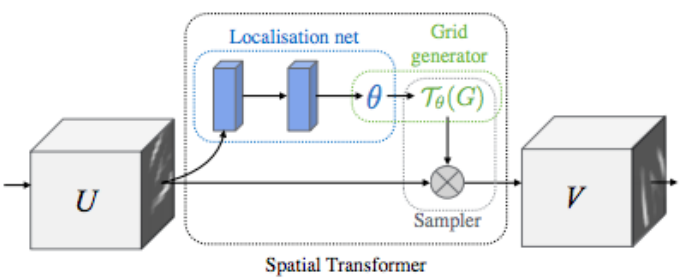

In [3]:
from IPython import display
display.Image("files/network.png")

In [4]:
# from STN import SimpleSTN

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


baseline_model = Net().to(device)
# from torch.utils.tensorboard import SummaryWriter
# baseline_model = SimpleSTN()
# images, labels = next(iter(train_loader))
# grid = torchvision.utils.make_grid(images)
# baseline_logger = SummaryWriter()
# baseline_logger.add_image("images", grid)
# baseline_logger.add_graph(baseline_model, images)
# baseline_logger.close()


model = Net().to(device)
print(model)


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (localization): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
  )
  (fc_loc): Sequential(
    (0): Linear(in_features=90, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=6, bias=True)
  )
)


## Define the trainer and evaluation functions 

In [5]:
optimizer = optim.SGD(model.parameters(), lr=0.01)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        # loss =  F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        # baseline_logger.add_scalar("Loss", loss, epoch)
#
# A simple test procedure to measure the STN performances on MNIST.
#


def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # test_loss += F.cross_entropy(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))
        # baseline_logger.add_scalar("Correct", correct, epoch)
        # baseline_logger.add_scalar("Accuracy", correct/ len(train_loader.dataset), epoch)

## Start Training the Model!! 

In [6]:
for epoch in range(1, 20 + 1):
    train(epoch)
    test()


/home/sanket/miniconda3/envs/docseg/lib/python3.6/site-packages/torch/nn/functional.py:3447: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/sanket/miniconda3/envs/docseg/lib/python3.6/site-packages/torch/nn/functional.py:3384: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.265845
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.834594


/home/sanket/miniconda3/envs/docseg/lib/python3.6/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.2409, Accuracy: 9298/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.493335
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.335702

Test set: Average loss: 0.1331, Accuracy: 9613/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.525171
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.186007

Test set: Average loss: 0.1024, Accuracy: 9671/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.327096
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.212728

Test set: Average loss: 0.0799, Accuracy: 9753/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.073932
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.467221

Test set: Average loss: 0.0675, Accuracy: 9799/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.298138
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.060862

Test set: Average loss: 0.0721, Accuracy: 9793/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.144250
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.102274

Test set: Average loss: 0.0603, Accuracy: 9820/10000 (98%)

Tra

##  Inference

### The model trains for 20 epochs and achieves a validation accuracy of 98.82% and a loss of 0.0387. The loss converges quite quickly as we visualize. 

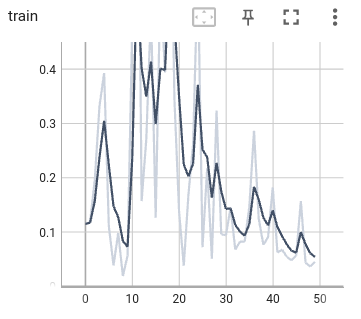

In [10]:
from IPython import display
display.Image("files/loss_curve.png")

### Here is a loss curve (train loss) a bit of a roller coaster until it converges in the end.(We continued the training for 50 epochs.)

## Visualize the Output of STN Layer

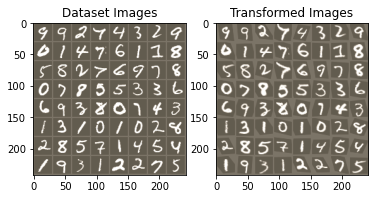

In [7]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()

# Task 2: Spatial Transformer Networks (STNs) with CoordConv Layers

* Liu et al. [3]  proposed the concept of CoordConv layer, where vanilla stacks of convolutional layers fail on the simple problem of performing a mapping from a Cartesian representation to a pixel-based representation.

* For the case of MNIST, we map a tensor of shape (C=1, H=28, W=28) to (C=3, H=28, W=28), where the two added channels contain untrained constant positional coordinates (i, j) for each of the tensor entries, with these coordinates linearly scaled between [-1, 1].

* The key advantage of CoordConv is that it allows to control the degree of translation dependence according to the task to be solved.

* The baseline STN model presented Task 1 convolutional layers both in the forward function as well as in the localization network. But in the next two subsections, the forward pass convolutions are replaced by CoordConv layer, but we make a distinction on whether CoordConv is also used within the localization network, and examine whether this has a noticeable effect on performance or not.

## Define a CoordConv Layer CoordConv() from original implementation

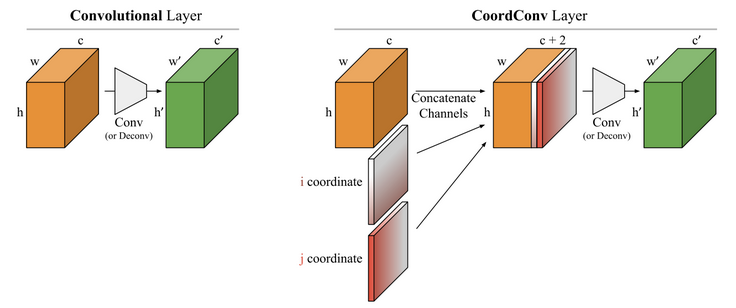

In [27]:
from IPython import display
display.Image("files/coordconv.png")

In [13]:
import torch
from torch import nn

class AddCoords(nn.Module):
    """
    This is a Pytorch implementation for this model comparison project,
    which is based on the original TF implementation
    of CoordConv by Liu et al. (2018, arXiv:1807.03247) available at
    https://github.com/uber-research/CoordConv/blob/master/CoordConv.py.
    Supports rank-2 tensors only.
    """

    def __init__(self, x_dim=None, y_dim=None, with_r=False):
        """
        Args:
          x_dim: Width of the image.

          y_dim: Height of the image.

          with_r: Whether to add an r-coordinate channel.
        """

        super(AddCoords, self).__init__()
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.with_r = with_r

    def forward(self, input_tensor):
        """
        Args:
          input_tensor: (N, C, H, W).
        """

        if len(input_tensor.shape) != 4:
            raise NotImplementedError("Only rank-2 tensors implemented.")

        batch_size_tensor = input_tensor.shape[0]

        # X channel
        xx_ones = torch.ones([1, self.y_dim], dtype=torch.int32)
        xx_ones = xx_ones.unsqueeze(-1)

        xx_range = torch.arange(self.x_dim, dtype=torch.int32).unsqueeze(0)
        xx_range = xx_range.unsqueeze(1)

        xx_channel = torch.matmul(xx_ones, xx_range)
        xx_channel = xx_channel.unsqueeze(-1)

        yy_ones = torch.ones([1, self.x_dim], dtype=torch.int32)
        yy_ones = yy_ones.unsqueeze(1)

        yy_range = torch.arange(self.y_dim, dtype=torch.int32).unsqueeze(0)
        yy_range = yy_range.unsqueeze(-1)

        yy_channel = torch.matmul(yy_range, yy_ones)
        yy_channel = yy_channel.unsqueeze(-1)


        # Normalize to [-1, 1]

        xx_channel = xx_channel.permute(0, 3, 2, 1)
        yy_channel = yy_channel.permute(0, 3, 2, 1)
        xx_channel = xx_channel.type_as(input_tensor)
        yy_channel = yy_channel.type_as(input_tensor)
        
        xx_channel = xx_channel.float() / (self.y_dim - 1)
        yy_channel = yy_channel.float() / (self.x_dim - 1)
        xx_channel = xx_channel*2 - 1
        yy_channel = yy_channel*2 - 1

        xx_channel = xx_channel.repeat(batch_size_tensor, 1, 1, 1)
        yy_channel = yy_channel.repeat(batch_size_tensor, 1, 1, 1)

        ret = torch.cat([input_tensor, xx_channel, yy_channel], dim=1)

        # Extra r-coordinate channel
        if self.with_r:
            rr = torch.sqrt(torch.pow(xx_channel - 0.5, 2) +
                            torch.pow(yy_channel - 0.5, 2))
            ret = torch.cat([ret, rr], dim=1)
        ret = ret.type_as(input_tensor)

        return ret


class CoordConv(nn.Module):
    """
    2D-CoordConv layer. Adds (i, j) coordinate information
    to the original input tensor as two additional channels.
    """

    def __init__(self, x_dim, y_dim, with_r, *args, **kwargs):
        """
        Args:
          x_dim: Width of the image.

          y_dim: Height of the image.

          with_r: Whether to add an r-coordinate channel.

          *args, **kwargs: Conv2d parameters.
        """

        super(CoordConv, self).__init__()
        self.addcoords = AddCoords(x_dim=x_dim, y_dim=y_dim, with_r=with_r)
        kwargs['in_channels'] = kwargs['in_channels'] + 2 + with_r
        self.conv = nn.Conv2d(*args, **kwargs)


    def forward(self, input_tensor):
        ret = self.addcoords(input_tensor)
        ret = self.conv(ret)
        return ret


## Define the new Network with the CoordConv Layers replacing the Conv layers 

* Case 1: Replace only forward pass Conv layers by the CoordConv layers but not in the Localization Network
* Case 2: Replace both forward pass Conv layers and ones in the localization network by CoordConv layers 

In [14]:
class CoordNet(nn.Module):
    """
    Pytorch implementation of a STN with Convolution layers
    replaced by Coordinate Convolution layers(Liu et. al., 2018)
    """
    def __init__(self, coordconv_localization=False, with_r=False):
        super(CoordNet, self).__init__()
        
        self.with_r = with_r
        self.coordconv_localization = coordconv_localization
        # self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.coordconv1 = CoordConv(x_dim=28, y_dim=28, with_r=self.with_r, in_channels=1, out_channels=10, kernel_size=5)
        self.coordconv2 = CoordConv(x_dim=12, y_dim=12, with_r=self.with_r, in_channels=10, out_channels=20, kernel_size=5)
        # self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        # self.conv2_drop = nn.Dropout2d()
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network 
        if self.coordconv_localization:
            self.localization = nn.Sequential(
            CoordConv(x_dim=28, y_dim=28, with_r=self.with_r,in_channels = 1, out_channels = 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            CoordConv(x_dim=11, y_dim=11, with_r=self.with_r, in_channels=8, out_channels=10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )
        else:
            self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        
            )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size(), align_corners=False)
        x = F.grid_sample(x, grid, align_corners=False)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.coordconv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.coordconv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model_coord = CoordNet().to(device)


## Case 1 Results (No change in Localization Network)

In [23]:
model_coord

CoordNet(
  (coordconv1): CoordConv(
    (addcoords): AddCoords()
    (conv): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  )
  (coordconv2): CoordConv(
    (addcoords): AddCoords()
    (conv): Conv2d(12, 20, kernel_size=(5, 5), stride=(1, 1))
  )
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (localization): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
  )
  (fc_loc): Sequential(
    (0): Linear(in_features=90, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=6, bias=True)
  )
)

In [24]:
optimizer = optim.SGD(model_coord.parameters(), lr=0.01)


def train(epoch):
    model_coord.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model_coord(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure the STN performances on MNIST.
#


def test():
    with torch.no_grad():
        model_coord.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model_coord(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

In [25]:
for epoch in range(1, 20 + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.119973
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.414967

Test set: Average loss: 0.0389, Accuracy: 9879/10000 (99%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.065518
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.034834

Test set: Average loss: 0.0409, Accuracy: 9876/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.055321
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.034992

Test set: Average loss: 0.0376, Accuracy: 9880/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.057934
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.121154

Test set: Average loss: 0.0356, Accuracy: 9885/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.045056
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.049430

Test set: Average loss: 0.0421, Accuracy: 9871/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.071662
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.154973

Test set: Average loss: 0.0304, Accuracy: 9904/10000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.066700
Train Epoch: 7 [320

##  Inference

### The model trains for 20 epochs and achieves a validation accuracy of 99.01% and a loss of 0.0322. The loss converges quite quickly as we visualize. 

In [28]:
coordconv_with_localization = CoordNet(coordconv_localization=True, with_r=True)
model_loc = coordconv_with_localization.to(device)

optimizer = optim.SGD(model_loc.parameters(), lr=0.01)


def train(epoch):
    model_loc.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model_loc(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure the STN performances on MNIST.
#


def test():
    with torch.no_grad():
        model_coord.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model_loc(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

## Case 2 Results (Modifying the Localization Network) 

In [26]:
print(model_loc)

CoordNet(
  (coordconv1): CoordConv(
    (addcoords): AddCoords()
    (conv): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  )
  (coordconv2): CoordConv(
    (addcoords): AddCoords()
    (conv): Conv2d(12, 20, kernel_size=(5, 5), stride=(1, 1))
  )
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (localization): Sequential(
    (0): CoordConv(
      (addcoords): AddCoords()
      (conv): Conv2d(3, 8, kernel_size=(7, 7), stride=(1, 1))
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): CoordConv(
      (addcoords): AddCoords()
      (conv): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1))
    )
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
  )
  (fc_loc): Sequential(
    (0): Linear(in_features=90, out_features=32, bias=Tr

In [29]:
for epoch in range(1, 30 + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.296297
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.175645


/home/sanket/miniconda3/envs/docseg/lib/python3.6/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.6526, Accuracy: 8026/10000 (80%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.726439
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.296562

Test set: Average loss: 0.3466, Accuracy: 8973/10000 (90%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.512370
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.259942

Test set: Average loss: 0.2854, Accuracy: 9202/10000 (92%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.177405
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.128846

Test set: Average loss: 0.2181, Accuracy: 9367/10000 (94%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.240545
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.103802

Test set: Average loss: 0.2457, Accuracy: 9263/10000 (93%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.140855
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.284945

Test set: Average loss: 0.1887, Accuracy: 9506/10000 (95%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.304939
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.184874

Test set: Average loss: 0.1941, Accuracy: 9425/10000 (94%)

Tra

## Inference (Quantitative Analysis)

### The STN that includes CoordConv layers in localization network actually achieves a better accuracy compared to one with no CoordConv layers on the localization network. Also, the CoordConv takes a longer time to get a better accuracy and convergence in the loss curves as compared to the Baseline STN. The improvement in MNIST dataset is quite marginal as MNIST is a good dataset for fast experimentation, but it might not be the best choice to benchmark the the extent of the improvement that these transformations can provide, since the input images are relatively simple with a limited degree of variation in terms of translation, rotation and scaling. These types of models might have a more interesting use in other domains such as pose estimation or OCR or anomaly detection, where the instances can have high variability in terms of these transformations. The applications of these models are not limited to the task of classification either, and can be of use for other learning types such as in generative models (for example, in GANs CoordConv can actually help to prevent mode collapse [5]). We will provide a table with summary of our models and experiments and the accuracy they obtained. 

| Model Variant | Accuracy | Best Epoch |
| --- | --- | --- |
| Simple Conv     | 0.9879 | 48 |
| Simple STN+Conv | 0.9889 | 44 |
| Simple STN+CoordConv| 0.9850| 43 |
| Simple STN+CoordConv+localization| 0.9910 | 47 |
| Simple STN=CoordConv+localization+r-channel| 0.9868 | 40 |


## Baseline-STN vs CoordConv-STN



/home/sanket/miniconda3/envs/docseg/lib/python3.6/site-packages/torch/nn/functional.py:3447: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/sanket/miniconda3/envs/docseg/lib/python3.6/site-packages/torch/nn/functional.py:3384: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


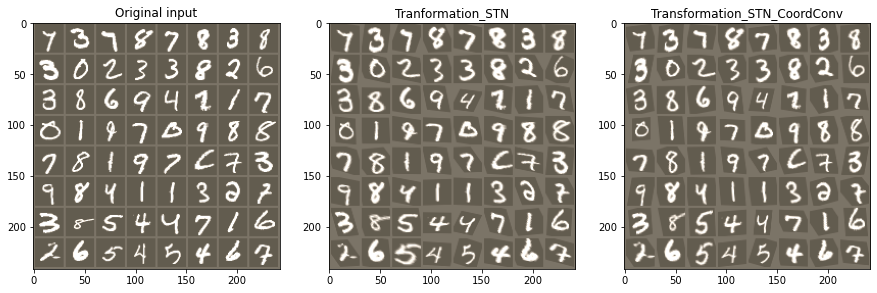

In [33]:
from utils import compare_stns
model.to(device)
model_coord.to(device)
model.eval()
model_coord.eval()

compare_stns(model, model_coord, 'Tranformation_STN', 'Transformation_STN_CoordConv', test_loader, device)

plt.show()


## Qualitative Inference: There is not much of a reasonable difference in the transformations learned with the CoordConv layers vs the standard Convolutional layers in the MNIST digit classification task. The above plot shows a batch of data taken from the etst set. The baseline-STN learns a transformation, in some cases quite different from the CoordConv-STN transformations. 

# Task 3: Vision Transformers (An Alternate Visual Attention Approach)

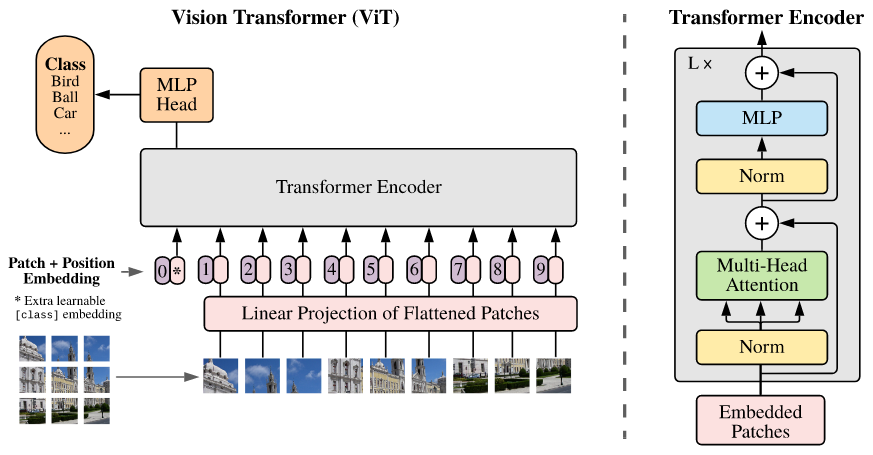

In [32]:
from IPython import display
display.Image("files/vit.png")

### The basic idea of the Vision Transformers is to split an image into fixed-size patches, linearly embed each of them, add position embeddings, and feed the resulting sequence of vectors to a standard Transformer encoder. In order to perform classification, we use the standard approach of adding an extra learnable “classification token” to the sequence. Adding a Multi-Head attention on top of embadded visual patches of an image can actually help massively to gain richer features.   

## Preparing Model 

In [41]:
# from vit_pytorch import VisionTransformer

def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W]
    x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W]
    return x


class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x


class VisionTransformer(nn.Module):
    def __init__(
        self,
        embed_dim,
        hidden_dim,
        num_channels,
        num_heads,
        num_layers,
        num_classes,
        patch_size,
        num_patches,
        dropout=0.0,
    ):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels * (patch_size ** 2), embed_dim)
        self.transformer = nn.Sequential(
            *(AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers))
        )
        self.mlp_head = nn.Sequential(nn.LayerNorm(embed_dim), nn.Linear(embed_dim, num_classes))
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))


    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.pos_embedding[:, : T + 1]

        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return F.log_softmax(out, dim=1)

model_vit = VisionTransformer(embed_dim=64,
        hidden_dim=128,
        num_channels=1,
        num_heads=8,
        num_layers=6,
        num_classes=64,
        patch_size=7,
        num_patches=64,
        dropout=0.2)

model_vit.to(device)
model_vit

VisionTransformer(
  (input_layer): Linear(in_features=49, out_features=64, bias=True)
  (transformer): Sequential(
    (0): AttentionBlock(
      (layer_norm_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): _LinearWithBias(in_features=64, out_features=64, bias=True)
      )
      (layer_norm_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (linear): Sequential(
        (0): Linear(in_features=64, out_features=128, bias=True)
        (1): GELU()
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=128, out_features=64, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
    (1): AttentionBlock(
      (layer_norm_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): _LinearWithBias(in_features=64, out_features=64, bias=True)
      )
      (layer_norm_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (linea

## Preparing ViT Trainer 

In [42]:
optimizer = optim.SGD(model_vit.parameters(), lr=0.01)


def train(epoch):
    model_vit.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model_vit(data)
        loss = F.nll_loss(output, target)
        # loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure the STN performances on MNIST.
#


def test():
    with torch.no_grad():
        model_coord.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model_vit(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # test_loss += F.cross_entropy(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

In [43]:
for epoch in range(1, 30 + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 4.266039
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.270105


/home/sanket/miniconda3/envs/docseg/lib/python3.6/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 1.8532, Accuracy: 3294/10000 (33%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.842807
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.520769

Test set: Average loss: 1.1441, Accuracy: 6259/10000 (63%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.168663
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.779770

Test set: Average loss: 0.6135, Accuracy: 8085/10000 (81%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.842282
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.311380

Test set: Average loss: 0.4564, Accuracy: 8607/10000 (86%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.378524
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.541634

Test set: Average loss: 0.3749, Accuracy: 8845/10000 (88%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.257324
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.359601

Test set: Average loss: 0.3265, Accuracy: 8995/10000 (90%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.221063
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.365100

Test set: Average loss: 0.2919, Accuracy: 9100/10000 (91%)

Tra

## Inference on ViT 

### Current State-of-the-art visual attention models relying on transformers (self-attention modules) have been trending recently. The usage of transformers has also been recently explored within the field of computer vision: an image is split into patches (analogous to tokens or sequences in NLP) and the linear embeddings of these patches are used as input for the transformer. Dosovitskiy et al. [5] show in their work that vision transformers can perform as well as CNNs. 

### Vision Transformers benefit a lot from pre-training and they lack generalization with smaller amounts of data. CNNs contain inductive biases which transformers do not have. Hence CNNs can learn distance between the pixels for their spatial reasoning ability. Transformers work in a way where they learn relationships between the image patches. Since these patch sequences are kind of sparse, large data is needed to train them efficiently. 

### In the given experiments we are training on the MNIST dataset from scratch, hence worse results are expected on the classification accuracy. But still, a classification accuracy of around 96% is managed on the MNIST test set.

# References

1. Jaderberg, Max, et al. “Spatial Transformer Networks.” ArXiv:1506.02025 [Cs], Feb. 2016. arXiv.org, http://arxiv.org/abs/1506.02025.
2. https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html (Pytorch Tutorial by HAMRAOUNI)
3. Liu, Rosanne, et al. An Intriguing Failing of Convolutional Neural Networks and the CoordConv Solution. July 2018. arxiv.org, https://arxiv.org/abs/1807.03247v2.
4. http://yann.lecun.com/exdb/mnist/ (THE MNIST DATABASE of HANDWRITTEN DIGITS)
5. Dosovitskiy, Alexey, et al. An Image Is Worth 16x16 Words: Transformers for Image Recognition at Scale. Oct. 2020. arxiv.org, https://arxiv.org/abs/2010.11929v2.

# Source Code References

1. https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html
2. https://github.com/lucidrains/vit-pytorch
3. https://github.com/uber-research/CoordConv


